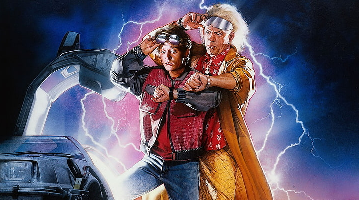

<p> <big> <i>"— What about all that talk about screwing up future events? The space-time continuum?
<p> — Well, I figured, what the hell."

<p> <i>"— А как же все эти разговоры, что нельзя менять будущее? Пространственно-временной континуум? 🙉
<p> — Да я подумал, ну его к чёрту этот континуум. 👹 

## Описание работы

Просмотр фильмов на оргинальном языке - популярный и действенный метод прокачаться при изучении иностранного языка. 
<p> Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимает 50 - 70 % диалогов. 👌 

**Цель проекта:** в течение двух недель разработать ML решение для автоматического определения уровня сложности англоязычных фильмов.

**План работы:**
1. Загрузить и ознакомиться с данными.
2. Провести предобработку данных.
3. Загрузить субтитры в датасет.
4. Подготовить данные для дальнейшего обучения.
5. Определить осноные метрики качества модели.
6. Обучение модели с побором гиперпараметров.
7. Оценка модели на тестовой выборке.

## Загрузка необходимых библиотек

In [1]:
!pip install chardet -q
!pip install pysrt -q
!pip install spacy -q
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
####Review
import os
from os import listdir
import zipfile
import numpy as np
import pandas as pd

import pysrt
from chardet.universaldetector import UniversalDetector
import spacy
import re
import string
from bs4 import BeautifulSoup
import nltk
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
!pip install optuna -q
!pip install lightgbm -q
!pip install ydata-profiling -q
###!pip install xgboost
!pip install catboost -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [4]:
# импортируем общие библиотеки
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import itertools
import pickle
from numpy.random import RandomState
from scipy.stats import randint
from scipy import stats as st
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

import warnings
warnings.filterwarnings("ignore")

#import xgboost 
#import catboost 
#import lightgbm
#import optuna
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
#from ydata_profiling import ProfileReport
from tqdm import tqdm

In [5]:
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 200
RNDST = 42

In [6]:
HTML = r'<.*?>' # html тэги меняем на пробел
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
UPPER = r'[[A-Za-z ]+[\:\]]' # указания на того кто говорит (BOBBY:)
LETTERS = r'[^a-zA-Z\'.,!? ]' # все что не буквы меняем на пробел 
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа

def clean_subs(subs):
    subs = subs[1:] # удаляем первый рекламный субтитр
    txt = re.sub(HTML, ' ', subs.text) # html тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
    txt = re.sub(UPPER, ' ', txt) # указания на того кто говорит (BOBBY:)
    txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
    txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
    txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
    txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
    txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
    txt = txt.lstrip() # обрезка пробелов слева
    txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы   
    txt = txt.lower() # текст в нижний регистр
    return txt

def get_encoding(path):
    detector = UniversalDetector() 
    with open(path, 'rb') as file:
        for line in file:
            detector.feed(line)
            if detector.done:
                break
    detector.close()
    return detector.result['encoding']

def read_subs(path):
    subs = pysrt.open(path, get_encoding(path))
    text = ''
    for sub in subs:
        text += (sub.text + ' ')
    return text

## Загрузка, анализ и предобработка данных

Перед анализом файла movies_labels, убедимся, что все файлы в наличии

In [7]:
### Review
labels = pd.read_excel('/kaggle/input/subtitles/movies_labels.xlsx',index_col=0)
labels.head(3)

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2


In [8]:
labels.Level.value_counts()

Level
B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: count, dtype: int64

In [9]:
labels['Subtitles']= np.nan
labels['coding']= np.nan # Дополнительная проверка

labels.head(3)
len(labels.Movie)

241

In [10]:
### Review
##film_list = []
list_not_iclude=[]
movie_list = labels.Movie
dir_list = ['A2', 'B1', 'B2', 'C1', 'Subtitles']
for i in tqdm(range(len(movie_list)), total=len(movie_list)):
    #print(len(movie_list))
    #print(i)
#for i in tqdm(range(30), total=10):
    for dir_ in dir_list:
        #print(dir_)
        count_=0
        #print(count_)
        #print(dir_)
        try:
            path_ = '/kaggle/input/subtitles/Subtitles_all/' + dir_ +'/'+ movie_list[i]+'.srt'
            #print(path_)
                
            encoding_ = get_encoding(path_)
            #print(encoding_)
            text_ = clean_subs(pysrt.open(path_, encoding=encoding_))
            #print(text_[:4])   
            labels.loc[i,'Subtitles'] = text_
            labels.loc[i,'coding'] = encoding_
            
        except:
            count_ += 1
            #print('except1')
            #print(movie_list[i])
            if count_ == 5:
                list_not_iclude.append(movie_list[i])
            continue
        

100%|██████████| 241/241 [01:10<00:00,  3.42it/s]


In [11]:
list_not_iclude

[]

In [12]:
labels[labels.duplicated(keep=False)]

,Movie,Level,Subtitles,coding
id,,,,
38,Powder(1995),B1,emt let's go everybody we need some help some help here get in here get in here she's close vitals are down to nothing here you go come on let me get in here you got her we're clear we're clear i ...,ascii
43,Inside_out(2015),B1,do you ever look at someone and wonder what is going on inside their head well i know well i know riley's head hmm and there she was hello riley oh look at you aren't you a little bundle of joy ar...,utf-8
44,Inside_out(2015),B1,do you ever look at someone and wonder what is going on inside their head well i know well i know riley's head hmm and there she was hello riley oh look at you aren't you a little bundle of joy ar...,utf-8
68,Powder(1995),B1,emt let's go everybody we need some help some help here get in here get in here she's close vitals are down to nothing here you go come on let me get in here you got her we're clear we're clear i ...,ascii


In [13]:
labels = labels.drop_duplicates()
labels.shape

(239, 4)

In [14]:
labels.query("Subtitles != Subtitles").count()

Movie        11
Level        11
Subtitles     0
coding        0
dtype: int64

In [15]:
labels.query("Subtitles != Subtitles")

,Movie,Level,Subtitles,coding
id,,,,
81,The Secret Life of Pets.en,B2,NaN,NaN
133,Valentine's.Day.2010.Subtitles.YIFY,B1,NaN,NaN
134,Angela's.Christmas.2018.WEBRip.Netflix,B2,NaN,NaN
154,Secrets Of Her Majesty's Secret Service eng,B2,NaN,NaN
160,Suits.Episode 13- God's Green Earth,B2,NaN,NaN
235,Glass Onion,B2,NaN,NaN
236,Matilda(2022),C1,NaN,NaN
237,Bullet train,B1,NaN,NaN
238,Thor: love and thunder,B2,NaN,NaN



"""
path_ = '/kaggle/input/subtitles/Subtitles_all/A2/The Walking Dead-S01E01-Days Gone Bye.English.srt'
encoding_ = get_encoding(path_)
print(encoding_)
text_ = clean_subs(pysrt.open(path_, encoding=encoding_))
pysrt.open(path_, encoding=encoding_).text"""

In [16]:
labels = labels[labels["Subtitles"].notnull()]

In [17]:
labels.query("Movie != Movie")


,Movie,Level,Subtitles,coding
id,,,,


In [18]:
labels = labels[labels["Movie"].notnull()]

In [19]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 0 to 234
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      228 non-null    object
 1   Level      228 non-null    object
 2   Subtitles  228 non-null    object
 3   coding     228 non-null    object
dtypes: object(4)
memory usage: 8.9+ KB


### Текст загружен, данные очищены

In [20]:
# распределение фильмов по уровням сложности
labels.Level.value_counts()

Level
B2            94
B1            50
C1            39
A2/A2+        26
B1, B2         8
A2             6
A2/A2+, B1     5
Name: count, dtype: int64

In [21]:
# Упрощение уровней сложности фильмов
labels.loc[labels.Level == 'A2/A2+', 'Level'] = 'A2'
labels.loc[labels.Level == 'B1, B2', 'Level'] = 'B1'
labels.loc[labels.Level == 'A2/A2+, B1', 'Level'] = 'A2'

In [22]:
labels.Level.value_counts()

Level
B2    94
B1    58
C1    39
A2    37
Name: count, dtype: int64

In [23]:
meta_switch = 'make_mini12'
if meta_switch == 'make_mini':
    labels1=labels.copy()
    def smpl_(lev_str='A2',level_num=6, labels=labels):
        
        return list(labels[labels.Level == lev_str].sample(level_num).index)
    _ = smpl_() + smpl_(lev_str='B1') + smpl_(lev_str='B2') + smpl_(lev_str='C1')
    labels=labels.loc[_,:]

In [24]:
labels = labels.sort_index()

labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 0 to 234
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      228 non-null    object
 1   Level      228 non-null    object
 2   Subtitles  228 non-null    object
 3   coding     228 non-null    object
dtypes: object(4)
memory usage: 8.9+ KB


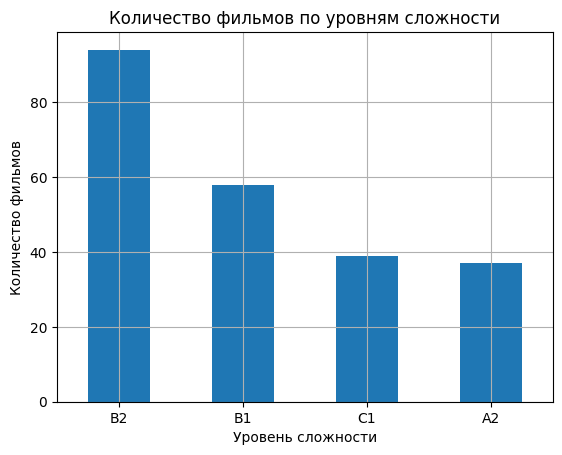

In [25]:
# график количества фильмов в датасете по уровню владения английским языком
labels.Level.value_counts().plot(kind='bar', title='Количество фильмов по уровням сложности', grid=True, 
                                 xlabel='Уровень сложности', ylabel='Количество фильмов', rot=0);

## Загрузка субтитров и словаря

#### И так, у нас 228 фильмов с субтитрами

In [26]:
labels.head()

,Movie,Level,Subtitles,coding
id,,,,
0,10_Cloverfield_lane(2016),B1,michelle please don't hang up just talk to me okay i can't believe you just left michelle come back please say something michelle talk to me look we had an argument couples fight that is no reason...,ascii
1,10_things_I_hate_about_you(1999),B1,i'll be right with you so cameron here you go nine schools in years my my army brat yeah my dad is that's enough i'm sure you won't find padua any different than your old schools same little ass w...,ascii
2,A_knights_tale(2001),B2,should we help him he's due in the lists in two minutes two minutes or forfeit lend us those right left dead eh three scores to none after two lances as long as sir ector doesn't fall off his hors...,ascii
3,A_star_is_born(2018),B2,get to it black eyes open wide it's time to testify there is no room for lies and everyone's waiting for you then i'm gone sitting by the phone and i'm all alone by the wayside and i'm gone sittin...,utf-8
4,Aladdin(1992),A2,where the caravan camels roam where it's flat and immense and the heat is intense it's barbaric but hey it's home when the wind's from the east and the sun's from the west and the sand in the glas...,utf-8


In [27]:
labels.shape

(228, 4)

In [28]:
labels.tail(4)

,Movie,Level,Subtitles,coding
id,,,,
231,Suits.S03E07.HDTV.x264-mSD,C1,it's going up on the wall tomorrow and this is your way of getting me on your side i don't want you on my side i want us to be on the same side i get ava hessington acquitted darby backs me for ma...,UTF-8-SIG
232,Suits.S03E08.480p.HDTV.x264-mSD,C1,darby backs me for managing partner i don't want it anymore get out of my sight you called mariga to offer him a bribe doesn't matter danny should never have had him in the first place but he does...,UTF-8-SIG
233,Suits.S03E09.480p.HDTV.x264-mSD,C1,i'm bonding with your father here speaking of which you're not taking it easy on me are you a little you mean something to me you've always meant something to me and you always will mean something...,UTF-8-SIG
234,Suits.S03E10.HDTV.x264-mSD,C1,this is a copy of the letter you wrote a copy to the district attorney when you threatened expose me you ever do send that letter you're in the same boat as me you want to move in here i've only e...,UTF-8-SIG


In [29]:
### DEL - почему-то это не требуется
labels = labels.reset_index(drop=True)

In [30]:
labels.head(4)

,Movie,Level,Subtitles,coding
0,10_Cloverfield_lane(2016),B1,michelle please don't hang up just talk to me okay i can't believe you just left michelle come back please say something michelle talk to me look we had an argument couples fight that is no reason...,ascii
1,10_things_I_hate_about_you(1999),B1,i'll be right with you so cameron here you go nine schools in years my my army brat yeah my dad is that's enough i'm sure you won't find padua any different than your old schools same little ass w...,ascii
2,A_knights_tale(2001),B2,should we help him he's due in the lists in two minutes two minutes or forfeit lend us those right left dead eh three scores to none after two lances as long as sir ector doesn't fall off his hors...,ascii
3,A_star_is_born(2018),B2,get to it black eyes open wide it's time to testify there is no room for lies and everyone's waiting for you then i'm gone sitting by the phone and i'm all alone by the wayside and i'm gone sittin...,utf-8


## Обработка

In [31]:
nlp = spacy.load("en_core_web_sm")

punctuations = string.punctuation #### Что это мы же все грохнули!!!! Оставили только слова

stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [32]:
def spacy_tokenizer(sentence):
    
    tokens = nlp(sentence)

    tokens = [word.lemma_.lower().strip() if word.lemma_ != "PROPN" else word.lower_ for word in tokens]
    
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
     
    return tokens

In [33]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [34]:
X = labels['Subtitles']
y = labels['Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.22, stratify = y, random_state = 42)

print(f'X_train dimension: {X_train.shape}')
print(f'y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}')
print(f'y_test dimension: {y_test.shape}')

X_train dimension: (177,)
y_train dimension: (177,)
X_test dimension: (51,)
y_test dimension: (51,)


## LogisticRegression

In [35]:
model_lr = LogisticRegression(random_state = 12345, class_weight='balanced')

pipeline_model_lr = Pipeline([('vectorizer', tfidf_vector),
                              ('classifier', model_lr )])

parameters = [{ 
              'classifier__solver': ['lbfgs'],
              'classifier__max_iter': [100,300],
              'classifier__penalty': ['l2'] 
             }]

SCORING = ['f1_weighted','balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted']

grid_search_lr = GridSearchCV(
              pipeline_model_lr,
              parameters,
              cv = 3, 
              verbose = 100,
              scoring = SCORING,
              refit = 'f1_weighted',              
              return_train_score = True
              )

grid_search_lr.fit(X_train,y_train)
metrics_columns_lr = [f'mean_test_{x}' for x in SCORING]
final_metrics_lr = pd.DataFrame(grid_search_lr.cv_results_)[metrics_columns_lr].iloc[grid_search_lr.best_index_]

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs
[CV 1/3; 1/2] END classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; balanced_accuracy: (train=0.976, test=0.658) f1_weighted: (train=0.966, test=0.683) precision_weighted: (train=0.968, test=0.753) recall_weighted: (train=0.966, test=0.678) roc_auc_ovr_weighted: (train=0.995, test=0.854) total time= 4.7min
[CV 2/3; 1/2] START classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs
[CV 2/3; 1/2] END classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; balanced_accuracy: (train=0.974, test=0.673) f1_weighted: (train=0.958, test=0.677) precision_weighted: (train=0.964, test=0.723) recall_weighted: (train=0.958, test=0.661) roc_auc_ovr_weighted: (train=0.997, test=0.842) total time= 4.6min
[CV 3/3; 1/2] START classifier__max_iter=100, classifier__penalty=l2, classifier__s

In [36]:
# Значение основных метрик
print(f'Значение f1:', grid_search_lr.cv_results_['mean_test_f1_weighted'][grid_search_lr.best_index_])
print(f'Значение accuracy:', grid_search_lr.cv_results_['mean_test_balanced_accuracy'][grid_search_lr.best_index_])
print(f'Значение precision:', grid_search_lr.cv_results_['mean_test_precision_weighted'][grid_search_lr.best_index_])
print(f'Значение recall:', grid_search_lr.cv_results_['mean_test_recall_weighted'][grid_search_lr.best_index_])
print(f'Значение auc-roc:', grid_search_lr.cv_results_['mean_test_roc_auc_ovr_weighted'][grid_search_lr.best_index_])

# Лучшие гиперпараметры модели
print(f'Лучшие параметры: {grid_search_lr.best_params_}')
print(f'Параметры модели: {grid_search_lr.best_estimator_}')

Значение f1: 0.6524485536300583
Значение accuracy: 0.6354166666666666
Значение precision: 0.7057948838669178
Значение recall: 0.6553672316384181
Значение auc-roc: 0.8355614911604087
Лучшие параметры: {'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Параметры модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d6b9f78d5a0>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=12345))])


In [37]:
# сохранение модели LogisticRegression
best_lr = grid_search_lr.best_estimator_
#with open('best_lr.pkl', "wb") as dataset:
#    pickle.dump(best_lr, dataset)

## GradientBoostingClassifier

In [38]:
%%time
model_gbc = GradientBoostingClassifier(random_state = 42)

pipeline_model_gbc = Pipeline([('vectorizer', tfidf_vector),
                              ('classifier', model_gbc )])
parameters = [{ 
#              'classifier__max_depth': [3],
              'classifier__learning_rate': [0.2],
              'classifier__subsample' : [1],
              'classifier__n_estimators' : [200, 300],
              'classifier__loss': ['log_loss'],
              'classifier__max_features':[None] 
}]

grid_search_gbc = GridSearchCV(
    pipeline_model_gbc,
    parameters,
    cv = 3, 
    verbose = 100,
    scoring = SCORING,         
    refit='f1_weighted',  
    return_train_score=True  
)

class_weights = compute_class_weight("balanced", classes = np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

grid_search_gbc.fit(X_train, y_train, classifier__sample_weight = sample_weights)

metrics_columns_gbc = [f'mean_test_{x}' for x in SCORING]
final_metrics_gbc = pd.DataFrame(grid_search_gbc.cv_results_)[metrics_columns_gbc].iloc[grid_search_gbc.best_index_]

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1
[CV 1/3; 1/2] END classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1; balanced_accuracy: (train=0.992, test=0.623) f1_weighted: (train=0.992, test=0.661) precision_weighted: (train=0.992, test=0.666) recall_weighted: (train=0.992, test=0.661) roc_auc_ovr_weighted: (train=1.000, test=0.869) total time= 5.1min
[CV 2/3; 1/2] START classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1
[CV 2/3; 1/2] END classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1; balanced_accuracy: (train=0.995, test=0.500) f1_wei

In [39]:
print(f'Значение f1:', grid_search_gbc.cv_results_['mean_test_f1_weighted']) ###[grid_search_lr.best_index_])
print(f'Значение accuracy:', grid_search_gbc.cv_results_['mean_test_balanced_accuracy']) ###[grid_search_lr.best_index_])
print(f'Значение precision:', grid_search_gbc.cv_results_['mean_test_precision_weighted']) ### [grid_search_lr.best_index_])
print(f'Значение recall:', grid_search_gbc.cv_results_['mean_test_recall_weighted']) ###[grid_search_lr.best_index_])
print(f'Значение auc-roc:', grid_search_gbc.cv_results_['mean_test_roc_auc_ovr_weighted']) ###[grid_search_lr.best_index_])

Значение f1: [0.58188464 0.59311804]
Значение accuracy: [0.54189815 0.55092593]
Значение precision: [0.59651347 0.60750092]
Значение recall: [0.59322034 0.60451977]
Значение auc-roc: [0.82737659 0.82723142]


In [40]:
#grid_search_gbc.cv_results_

In [41]:
# Значение основных метрик
##СТОП!!
print(f'Значение f1:', grid_search_gbc.cv_results_['mean_test_f1_weighted'][grid_search_gbc.best_index_])
print(f'Значение accuracy:', grid_search_gbc.cv_results_['mean_test_balanced_accuracy'][grid_search_gbc.best_index_])
print(f'Значение precision:', grid_search_gbc.cv_results_['mean_test_precision_weighted'][grid_search_gbc.best_index_])
print(f'Значение recall:', grid_search_gbc.cv_results_['mean_test_recall_weighted'][grid_search_gbc.best_index_])
print(f'Значение auc-roc:', grid_search_gbc.cv_results_['mean_test_roc_auc_ovr_weighted'][grid_search_gbc.best_index_])

# Лучшие гиперпараметры модели
print(f'Лучшие параметры: {grid_search_gbc.best_params_}')
print(f'Параметры модели: {grid_search_gbc.best_estimator_}')

Значение f1: 0.5931180446699226
Значение accuracy: 0.5509259259259259
Значение precision: 0.6075009174919969
Значение recall: 0.6045197740112994
Значение auc-roc: 0.8272314164494765
Лучшие параметры: {'classifier__learning_rate': 0.2, 'classifier__loss': 'log_loss', 'classifier__max_features': None, 'classifier__n_estimators': 300, 'classifier__subsample': 1}
Параметры модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d6b9f78d5a0>)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=300,
                                            random_state=42, subsample=1))])


In [42]:
# сохранение модели GradientBoostingClassifier
best_gbc = grid_search_gbc.best_estimator_
#with open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/best_gbc.pkl', "wb") as dataset:
#    pickle.dump(best_gbc, dataset)
best_gbc

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d6b9f78d5a0>)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=300,
                                            random_state=42, subsample=1))])

## Оценка модели на тестовой выборке

In [43]:
from sklearn.metrics import f1_score

predictions = grid_search_lr.predict(X_test)

print(f'Метрика F1 на обучающей выборке:{f1_score(grid_search_lr.predict(X_train), y_train, average="weighted")}')
print(f'Метрика F1 на тестовой выборке:{f1_score(predictions, y_test, average="weighted")}')

print('Классификационная таблица:')
print(classification_report(y_test, predictions))

Метрика F1 на обучающей выборке:0.9312975908015648
Метрика F1 на тестовой выборке:0.6315273477812178
Классификационная таблица:
              precision    recall  f1-score   support

          A2       0.00      0.00      0.00         8
          B1       0.40      0.77      0.53        13
          B2       0.79      0.71      0.75        21
          C1       1.00      0.67      0.80         9

    accuracy                           0.61        51
   macro avg       0.55      0.54      0.52        51
weighted avg       0.60      0.61      0.58        51



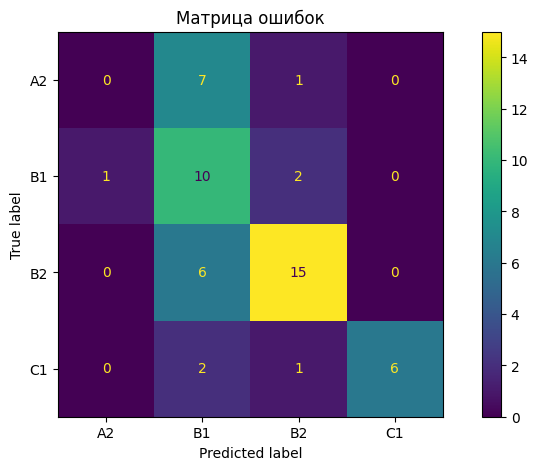

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax = ax)
_ = ax.set_title(f'Матрица ошибок')


In [45]:
best_model_lr = grid_search_lr.best_estimator_
#with open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/best_model_lr.pkl', "wb") as dataset:
#    pickle.dump(best_model_lr, dataset)

**Выводы:**
Основная цель работы состояла в разработке модели для автоматического определения уровня сложности фильмов.
Исходный файл содержал размеченные данные - название фильма и его ранг.

В начале проекта была проведена подготовка данных - получена кодировка текста и выполнено чтение \*.srt файлов для понимания реального наполнения данных:
1. В списке были фильмы без названия
2. Часть фильмов из списка отсутствовала
3. Присутствовали дубли
Так как данных в некоторых уровнях не очень много, было принято решение оставить только уровни - A2, B1, B2 и C1.

В ходе работы было произведено чтение субтитров с использованием библиотеки pysrt (в данном случае на этапе EDA), также была произведена обработка и токенизация текста.

В результате проведённого исследования, наилучшей моделью для автоматического определения уровня сложности англоязычных фильмов, неожиданно, оказалась логистическая регрессия (LogicsticRegression).

In [46]:
# Значение основных метрик
print(f'Значение f1:', grid_search_lr.cv_results_['mean_test_f1_weighted'][grid_search_lr.best_index_])
print(f'Значение accuracy:', grid_search_lr.cv_results_['mean_test_balanced_accuracy'][grid_search_lr.best_index_])
print(f'Значение precision:', grid_search_lr.cv_results_['mean_test_precision_weighted'][grid_search_lr.best_index_])
print(f'Значение recall:', grid_search_lr.cv_results_['mean_test_recall_weighted'][grid_search_lr.best_index_])
print(f'Значение auc-roc:', grid_search_lr.cv_results_['mean_test_roc_auc_ovr_weighted'][grid_search_lr.best_index_])

# Лучшие гиперпараметры модели
print(f'Лучшие параметры: {grid_search_lr.best_params_}')
print(f'Параметры модели: {grid_search_lr.best_estimator_}')

Значение f1: 0.6524485536300583
Значение accuracy: 0.6354166666666666
Значение precision: 0.7057948838669178
Значение recall: 0.6553672316384181
Значение auc-roc: 0.8355614911604087
Лучшие параметры: {'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Параметры модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7d6b9f78d5a0>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=12345))])
